# Introduction

Instacart, a grocery ordering and delivery app, is one of my favorite tech platforms. 

Back in 2017, the company announced its first public dataset release, which is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The goal is then to predict which previously purchased products will be in a user’s next order. In this post, I’ll do some exploratory analysis to get some surface-level insights about the dataset.

# Problem Definition

- What are the most popular products?
- When do they order again?

# Exploratory Analysis

In [91]:
# Load package and dataset
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
import plotly.express as px
import squarify #treemap
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation

order_products_train_df = pd.read_csv("data/order_products__train.csv")
order_products_prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df =pd.read_csv("data/orders.csv")
products_df =pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

## Orders

Firstly, let's explore **orders_df** file.

In [2]:
print("The orders data size is : ", orders_df.shape)
print("Columns in orders data are: ", orders_df.columns.values)

The orders data size is :  (3421083, 7)
Columns in orders data are:  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [3]:
# display first five rows of our dataset.
orders_df.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Check for missing data

In [4]:
orders_na = ((orders_df.isnull().sum())/len(orders_df))*100
orders_na

order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.027594
dtype: float64

The only missiong feature is **days_since_prior_order**  with **6%** missing, meaning 6% orders are customers' first-time order.

### Number of orders

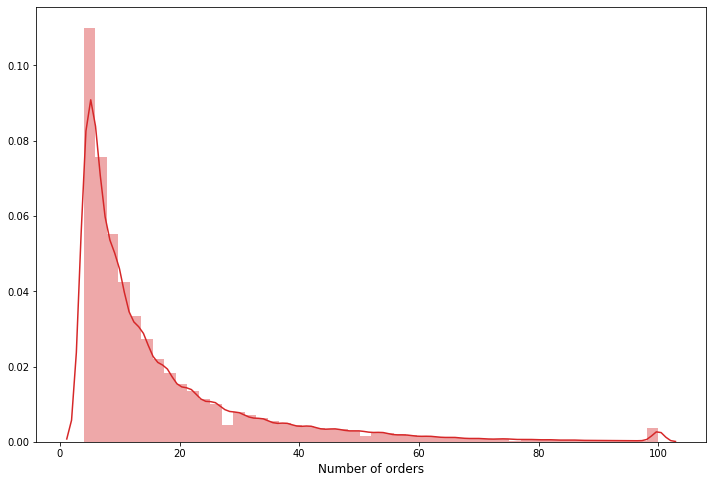

In [5]:
total_order = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
plt.figure(figsize = (12,8))
sns.distplot(total_order['order_number'],norm_hist = False,color = color[3])
plt.xlabel('Number of orders', fontsize =12)
plt.show()


Most customers ordered around 15 times on Instacart.

### Days of orders in a week

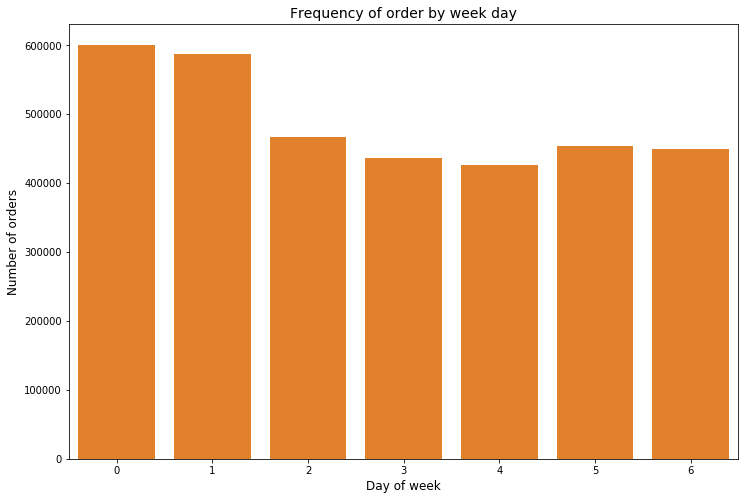

In [6]:
plt.figure(figsize = (12,8))
sns.countplot(orders_df['order_dow'],color = color[1])
plt.xlabel('Day of week',fontsize = 12)
plt.ylabel('Number of orders',fontsize = 12)
plt.title('Frequency of order by week day',fontsize = 14)
plt.show()

People usually order at days 0 and 1 (anonimyzed days and probably the Saturday and Sunday).

### Hours of orders in a day

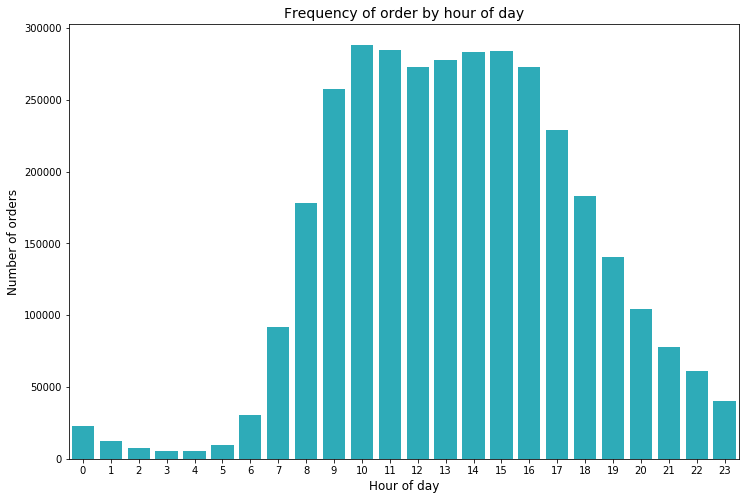

In [7]:
plt.figure(figsize = (12,8))
sns.countplot(orders_df['order_hour_of_day'],color = color[9])
plt.xlabel('Hour of day',fontsize = 12)
plt.ylabel('Number of orders',fontsize = 12)
plt.title('Frequency of order by hour of day',fontsize = 14)
plt.show()

Majority of the orders are made during day time. Most orders are placed between 8 and 18 (anonimyzed hours and probably between 8:00am and 6:00pm)

### Days and hours of orders

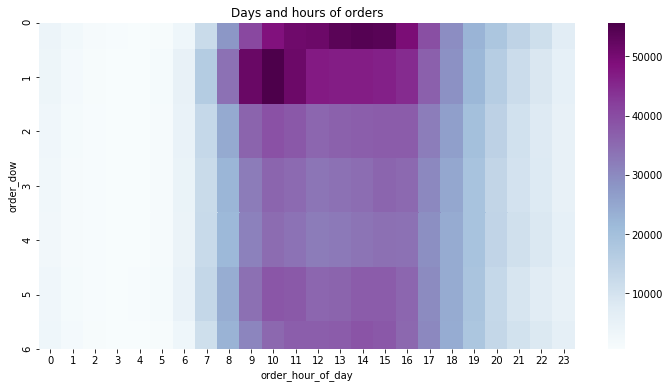

In [8]:
day_hour = orders_df.groupby(['order_dow','order_hour_of_day'])['order_number'].aggregate('count').reset_index()
day_hour_pv = day_hour.pivot('order_dow','order_hour_of_day','order_number')

plt.figure(figsize = (12,6))
sns.heatmap(day_hour_pv,cmap = 'BuPu')
plt.title("Days and hours of orders")
plt.show()

Probably **Satuday evenings** and **Sunday mornings** are the prime time for orders.

### Periods of reorder

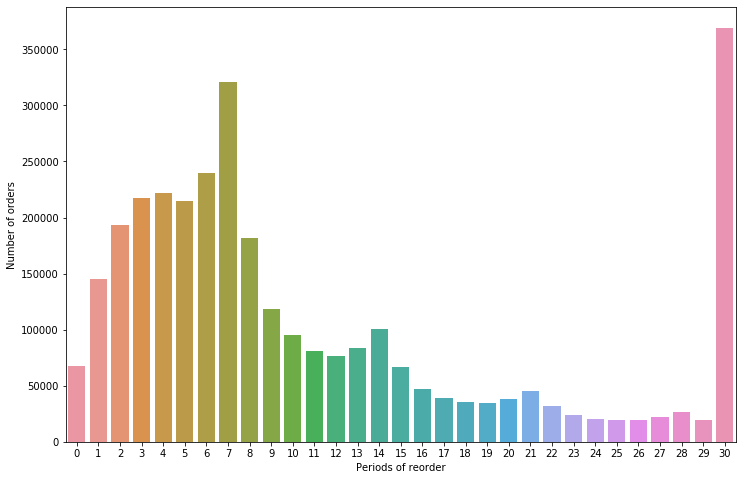

In [9]:
f, ax = plt.subplots(figsize = (12,8))
sns.countplot(x='days_since_prior_order',data = orders_df)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xlabel('Periods of reorder')
plt.ylabel('Number of orders')
plt.show()

Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

## Order Products

Let's explore **order_products_train_df** and **order_products_prior_df** files. These files specify which products were purchased in each order. More specifically, **order_products_prior** contains previous order contents for all customers and **order_products_train** contains the last orders for some customers only.

In [10]:
print("The order_products_train_df size is : ", order_products_train_df.shape)
print("The order_products_prior_df size is : ", order_products_prior_df.shape)

The order_products_train_df size is :  (1384617, 4)
The order_products_prior_df size is :  (32434489, 4)


In [11]:
order_products_train_df.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
order_products_prior_df.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Let's concatenate them in the same dataframe to better analysis the data.

In [13]:
order_products_all = pd.concat([order_products_train_df,order_products_prior_df],axis = 0)
print('The order_products_all size is :',order_products_all.shape)

The order_products_all size is : (33819106, 4)


In [14]:
order_products_all.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Check for missing data

In [15]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


There is no missing data in **order_products_all** dataset.

In [16]:
#Check for number of unique orders and unique products.
orders_unique = order_products_all.order_id.nunique()
products_unique = order_products_all.product_id.nunique()
print('There are {:,} orders for {:,} products'.format(orders_unique,products_unique))

There are 3,346,083 orders for 49,685 products


In [17]:
order_products_all.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Number of products in each order

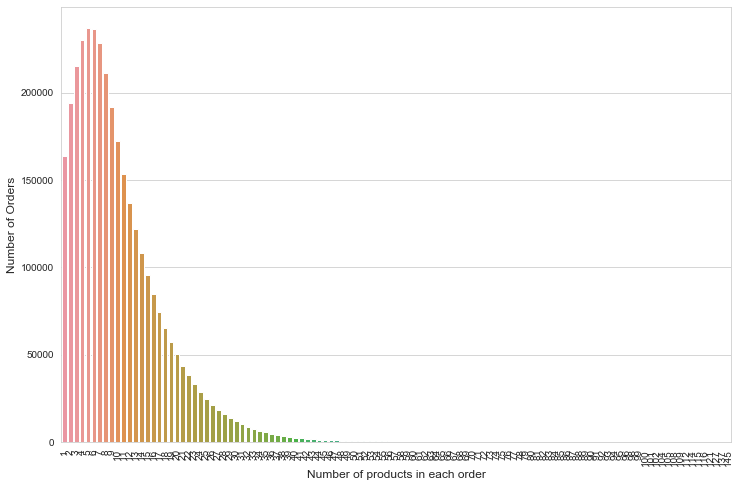

In [18]:
products = order_products_all.groupby("order_id")['add_to_cart_order'].max().reset_index()
plt.figure(figsize = (12,8))
sns.set_style('whitegrid')
sns.countplot('add_to_cart_order',data = products)
plt.ylabel('Number of Orders',fontsize = 12)
plt.xlabel("Number of products in each order",fontsize = 12)
plt.xticks(rotation = 90)
plt.show()

We can see that people usually order around 5 products each time.

In [19]:
# merge order_products_all with products_df, aisles_df and departments_df
order_products = pd.merge(order_products_all,products_df, on = 'product_id',how = 'left' )
order_products = pd.merge(order_products,aisles_df, on ='aisle_id', how = 'left')
order_products = pd.merge(order_products,departments_df,on='department_id',how = 'left')

In [20]:
order_products.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


### Most popular products

In [21]:
top_products = order_products['product_name'].value_counts().reset_index().head(10)
top_products.columns = ['Product_name','Total_reorders']
top_products

,Product_name,Total_reorders
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877
5,Organic Avocado,184224
6,Large Lemon,160792
7,Strawberries,149445
8,Limes,146660
9,Organic Whole Milk,142813


Fruits like banana, strawberries are the most popular products.

### Most popular departments

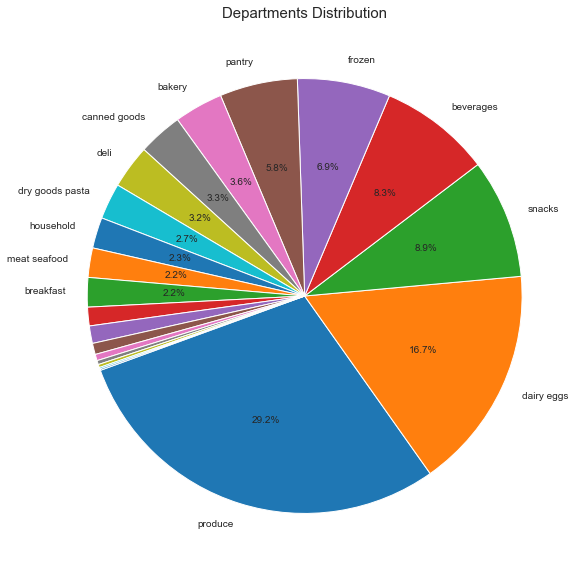

In [22]:
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 2 else ''
def get_new_labels(sizes, labels):
    new_labels = [label if size > 2 else '' for size, label in zip(sizes, labels)]
    return new_labels

plt.figure(figsize = (10,10))
department_sales = order_products['department'].value_counts()
labels = np.array(department_sales.index)
sizes = np.array((department_sales/department_sales.sum())*100)
plt.pie(sizes, labels = get_new_labels(sizes, labels), autopct = my_autopct, startangle = 200)
plt.title('Departments Distribution',fontsize = 15)
plt.show()

As we can see from the above, **Produce** are the most popular departments.

### Most popular aisles

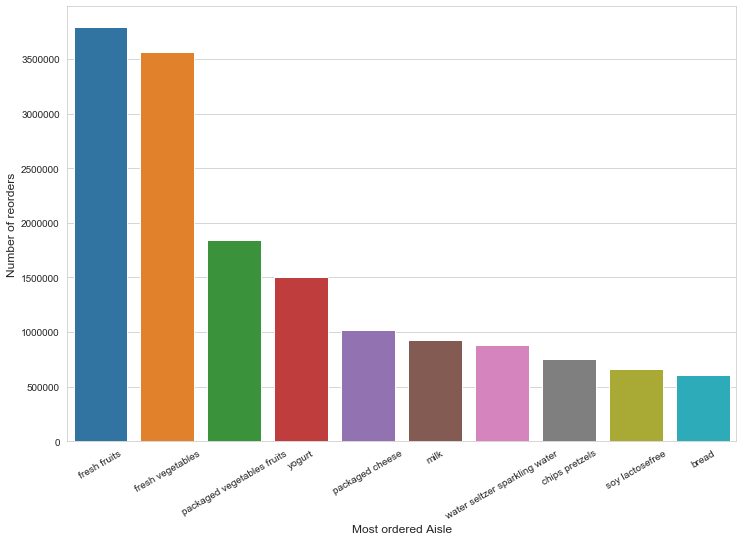

In [23]:
aisle = order_products['aisle'].value_counts().reset_index().head(10)
aisle.columns=['Aisle','Count']
plt.figure(figsize = (12,8))
sns.barplot(x='Aisle',y='Count',data = aisle)
plt.ylabel('Number of reorders',fontsize = 12)
plt.xlabel("Most ordered Aisle",fontsize = 12)
plt.xticks(rotation = 30)
plt.show()

**Fresh fruits** and **fresh vegetables** are the most popular aisles for customers.

### Do people always reorder the same previous ordered products?

In [24]:
reordered = order_products.groupby(['reordered'])['product_id'].count().reset_index()
reordered.columns = ['Reordered','Total_products']
reordered['Ratio'] = reordered['Total_products'].apply(lambda x: x/reordered['Total_products'].sum())
reordered

,Reordered,Total_products,Ratio
0,0,13863746,0.409938
1,1,19955360,0.590062


**59%** of ordered products are previously ordered by customers.

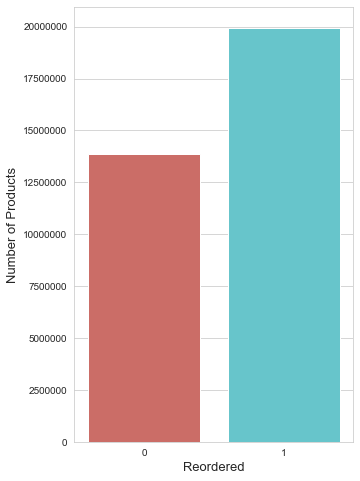

In [25]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot('Reordered', 'Total_products',data=reordered, palette='hls')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### Which product do customer put into the cart first?

In [79]:
product_count = order_products.product_name.value_counts().reset_index()
product_count.columns =['Product_name','Total_count']
add = order_products.groupby(['product_name','add_to_cart_order'])['product_id'].count().reset_index()
first_add = add[add['add_to_cart_order']==1]
first_add.columns =['Product_name','add_to_cart_order','add_to_order_count']
cart_first = pd.merge(first_add , product_count, on ='Product_name')
cart_first['first_add_ratio'] = cart_first['add_to_order_count']/cart_first['Total_count']
cart_first_final = cart_first[cart_first['add_to_order_count']>10][['Product_name','first_add_ratio']].sort_values(by='first_add_ratio',ascending = False).head(10)
cart_first_final

,Product_name,first_add_ratio
11631,Emergency Contraceptive,0.792453
32340,Rehab Energy Iced Tea Orangeade,0.787879
5346,California Champagne,0.777778
12802,"Flavored Vodka, Peach",0.708333
5154,"Cabernet Sauvignon, H3 Collection, Horse Heave...",0.700000
26596,Organic Raspberry Black Tea,0.692308
22568,Nasal Decongestant Inhaler with Medicated Vapors,0.688889
35452,Soy Powder Infant Formula,0.685714
11166,Draft Sake,0.675000
22106,More Milk Plus Herbal capsules,0.666667


Customers seem to be quite certain about Emergency Contraceptive and if they buy them, put them into their cart first in 79% of time.

### Most reordered products

Which products are usually reorded?

In [87]:
reorder_product = order_products.groupby(['product_name'])['reordered'].mean().sort_values(ascending = False).reset_index().head(10)
reorder_product.columns = ['Product','Reorder_ratio']
reorder_product

,Product,Reorder_ratio
0,Raw Veggie Wrappers,0.942029
1,Serenity Ultimate Extrema Overnight Pads,0.933333
2,Orange Energy Shots,0.923077
3,Chocolate Love Bar,0.921569
4,Soy Powder Infant Formula,0.914286
5,Simply Sleep Nighttime Sleep Aid,0.911111
6,"Energy Shot, Grape Flavor",0.909091
7,Russian River Valley Reserve Pinot Noir,0.900000
8,Bars Peanut Butter,0.898551
9,Soy Crisps Lightly Salted,0.895522


### Department wise reorder ratio

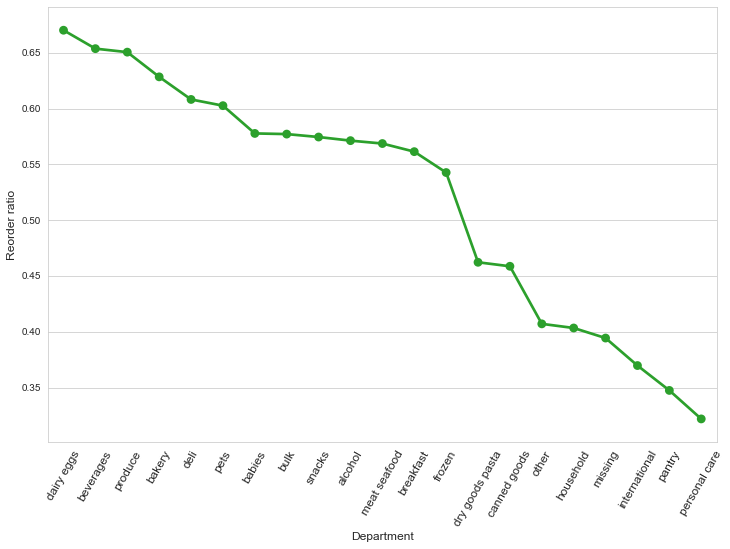

In [86]:
reorder_department = order_products.groupby(["department"])['reordered'].aggregate('mean').reset_index().sort_values(by = 'reordered',ascending = False)
plt.figure(figsize = (12,8))
sns.pointplot(x='department',y='reordered',data = reorder_department,alpha = 0.8,color = color[2])
plt.ylabel("Reorder ratio", fontsize =12)
plt.xlabel("Department",fontsize = 12)
plt.xticks(rotation = 60,fontsize = 12)
plt.show()

**Personal care** has the **lowest** reorder ratio and **dairy eggs** have the **highest** reorder ratio.

### Aisle - Reorder ratio:

In [115]:
reorder_aisle = order_products.groupby(['department','aisle'])['reordered'].mean().sort_values(ascending = False).reset_index(name = 'reordered_ratio')
reorder_aisle

,department,aisle,reordered_ratio
0,dairy eggs,milk,0.781812
1,beverages,water seltzer sparkling water,0.729930
2,produce,fresh fruits,0.718823
3,dairy eggs,eggs,0.706359
4,dairy eggs,soy lactosefree,0.692361
...,...,...,...
129,personal care,beauty,0.212858
130,personal care,first aid,0.195864
131,household,kitchen supplies,0.194802
132,pantry,baking supplies decor,0.167595


In [ ]:
plt.figure(figsize = (12,8))
plt.scatter()

### Add to Cart - Reorder ratio

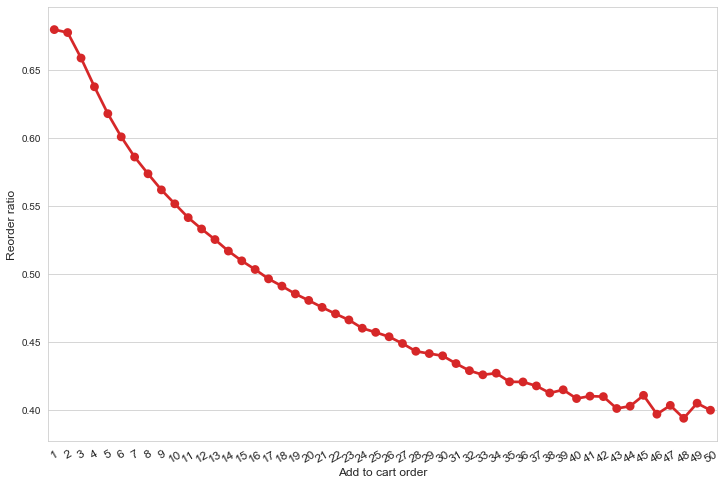

In [80]:
add_to_cart = order_products.groupby(['add_to_cart_order'])['reordered'].aggregate('mean').reset_index()
add_to_cart_mod = add_to_cart[add_to_cart['add_to_cart_order']<=50]
plt.figure(figsize = (12,8))
sns.pointplot(x='add_to_cart_order',y='reordered',data = add_to_cart_mod,alpha = 0.8, color = color[3])
plt.ylabel('Reorder ratio',fontsize =12)
plt.xlabel('Add to cart order',fontsize = 12 )
plt.xticks (rotation = 30, fontsize =12)
plt.show()

Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later. This makes sense to me as well since we tend to first order all the products we used to buy frequently and then look out for the new products available.

## Customers

Let's check the total number of unique customers in the three datasets (prior, train, test)

In [81]:
print("Number of unique customers in the whole dataset: ",orders_df.user_id.nunique())

Number of unique customers in the whole dataset:  206209


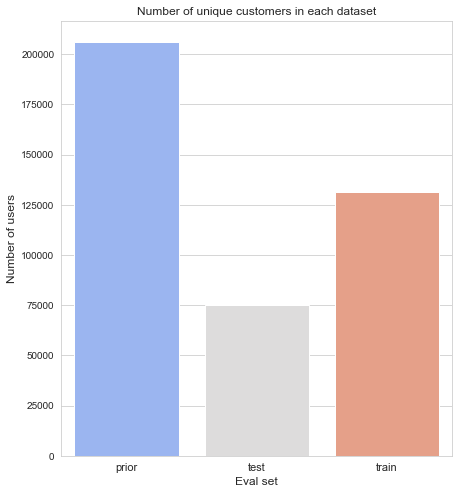

In [82]:
eval_set = orders_df.groupby("eval_set")["user_id"].nunique()
plt.figure(figsize=(7,8))
sns.barplot(eval_set.index, eval_set.values, palette='coolwarm')
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Eval set', fontsize=12)
plt.xticks(fontsize = 11)
plt.title("Number of unique customers in each dataset")
plt.show()

### Orders made by each customer

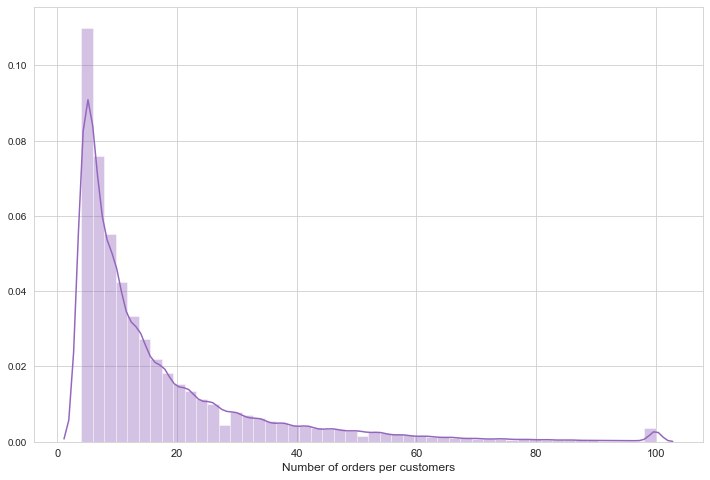

In [83]:
order_customers = orders_df.groupby('user_id')['order_id'].count()
plt.figure(figsize=(12,8))
sns.distplot(order_customers.values,norm_hist = False,color = color[4])
plt.xlabel('Number of orders per customers', fontsize=12)
plt.xticks(fontsize = 11)
plt.show()

Most customers made 4 orders.